# The Vision Transformer
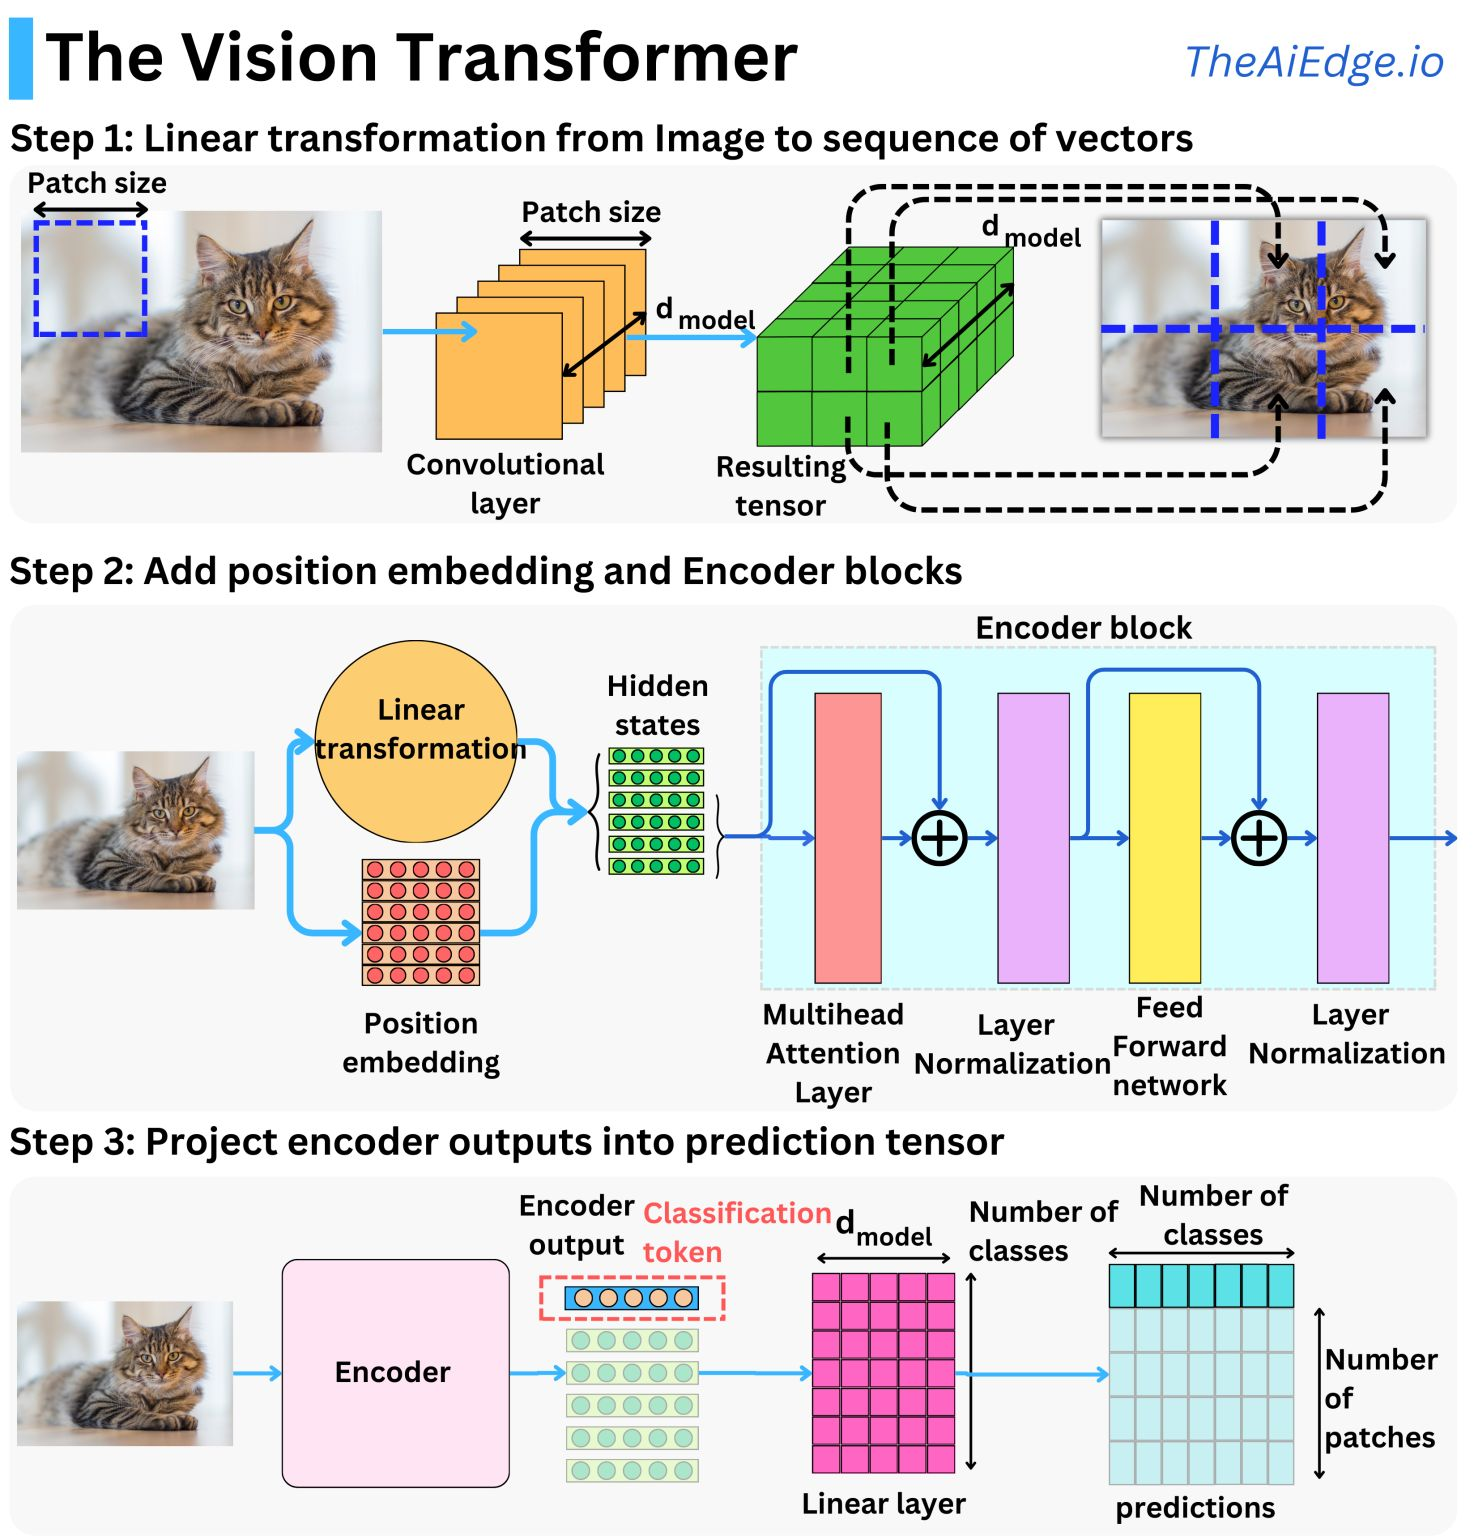

#Project name: The Vision Transformer
contributor: Rajeev singh sisodiya

project details: The Vision Transformer has slowly been replacing typical convolutional networks when it comes to image analysis tasks.

Nothing in the Transformer architecture is intrinsically bound to NLP applications! As long as you can format your data into a sequence of vectors, you can feed it to a Transformer. It might feel odd to think about an image as a sequence of vectors, though.

The idea is to build visual tokens by breaking down the image into patches of pixels and flattening them down into vectors through a linear transformation. With a convolutional layer, we can transform an image into a sequence of vectors in one shot. As soon as we have vectors, we can pass them into a Transformer, as you would any textual tokens.


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, LayerNormalization, MultiHeadAttention, Add

def VisionTransformer(image_size, patch_size, num_classes, num_heads, mlp_dim, depth):
  """
  Creates a Vision Transformer model.

  Args:
    image_size: The size of the input image (e.g., 224).
    patch_size: The size of the patches to extract (e.g., 16).
    num_classes: The number of classes to predict.
    num_heads: The number of attention heads.
    mlp_dim: The dimension of the MLP layer.
    depth: The number of encoder blocks.

  Returns:
    A Keras model.
  """

  # Step 1: Linear transformation from Image to sequence of vectors
  inputs = Input(shape=(image_size, image_size, 3))
  patches = Conv2D(filters=mlp_dim, kernel_size=patch_size, strides=patch_size)(inputs)
  patches = Flatten()(patches)

  # Step 2: Add position embedding and Encoder blocks
  position_embedding = tf.keras.layers.Embedding(input_dim=patches.shape[1], output_dim=mlp_dim)(tf.range(start=0, limit=patches.shape[1]))
  x = patches + position_embedding
  for _ in range(depth):
    x = EncoderBlock(num_heads, mlp_dim)(x)

  # Step 3: Project encoder outputs into prediction tensor
  x = Dense(num_classes)(x)

  return tf.keras.models.Model(inputs=inputs, outputs=x)

class EncoderBlock(tf.keras.layers.Layer):
  def __init__(self, num_heads, mlp_dim):
    super(EncoderBlock, self).__init__()
    self.attn = MultiHeadAttention(num_heads, key_dim=mlp_dim, value_dim=mlp_dim)
    self.norm1 = LayerNormalization()
    self.mlp = tf.keras.Sequential([
      Dense(mlp_dim, activation='gelu'),
      Dense(mlp_dim)
    ])
    self.norm2 = LayerNormalization()

  def call(self, x):
    x = self.norm1(x)
    x = self.attn(x, x, x)
    x = Add()([x, x])

    x = self.norm2(x)
    x = self.mlp(x)

    return Add()([x, x])

#Image Classification with Vision Transformer

 Below is a code, incorporating the provided Vision Transformer architecture into an image classification pipeline

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, LayerNormalization, MultiHeadAttention, Add, Reshape
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Define the Vision Transformer model
def VisionTransformer(image_size, patch_size, num_classes, num_heads, mlp_dim, depth):
  """
  Creates a Vision Transformer model.

  Args:
    image_size: The size of the input image (e.g., 224).
    patch_size: The size of the patches to extract (e.g., 16).
    num_classes: The number of classes to predict.
    num_heads: The number of attention heads.
    mlp_dim: The dimension of the MLP layer.
    depth: The number of encoder blocks.

  Returns:
    A Keras model.
  """

  # Step 1: Linear transformation from Image to sequence of vectors
  inputs = Input(shape=(image_size, image_size, 3))
  patches = Conv2D(filters=mlp_dim, kernel_size=patch_size, strides=patch_size)(inputs) # Extract patches
  num_patches = (image_size // patch_size) ** 2 # Calculate the number of patches
  patches = Reshape((num_patches, mlp_dim))(patches) # Reshape to (num_patches, mlp_dim)

  # Step 2: Add position embedding and Encoder blocks
  position_embedding = tf.keras.layers.Embedding(input_dim=num_patches, output_dim=mlp_dim)(tf.range(start=0, limit=num_patches)) # Create position embeddings
  x = patches + position_embedding  # Add position embeddings to each patch
  for _ in range(depth):
    x = EncoderBlock(num_heads, mlp_dim)(x)

  # Step 3: Project encoder outputs into prediction tensor
  x = LayerNormalization()(x) # Add layer normalization before the final dense layer
  x = Flatten()(x) # Flatten the output of the encoder blocks
  x = Dense(num_classes)(x) # Project to the number of classes

  return tf.keras.models.Model(inputs=inputs, outputs=x) # Return the Keras model

class EncoderBlock(tf.keras.layers.Layer):
  def __init__(self, num_heads, mlp_dim):
    super(EncoderBlock, self).__init__()
    self.attn = MultiHeadAttention(num_heads, key_dim=mlp_dim, value_dim=mlp_dim)
    self.norm1 = LayerNormalization()
    self.mlp = tf.keras.Sequential([
      Dense(mlp_dim, activation='gelu'),
      Dense(mlp_dim)
    ])
    self.norm2 = LayerNormalization()
    self.add = Add()

  def call(self, x):
    residual = x # Store the input as residual
    x = self.norm1(x) # Layer normalization
    x = self.attn(x, x, x) # Multi-head attention
    x = self.add([x, residual]) # Add residual connection

    residual = x # Store the result as residual
    x = self.norm2(x) # Layer normalization
    x = self.mlp(x) # MLP block
    x = self.add([x, residual]) # Add residual connection

    return x

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Preprocess the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Create data generators for augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_datagen.fit(x_train)

# Instantiate the Vision Transformer model
model = VisionTransformer(image_size=32, patch_size=4, num_classes=10, num_heads=8, mlp_dim=512, depth=6)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(x_test, y_test)
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test)
print('Test accuracy:', accuracy)